In [22]:
# Wczytanie 2 języków z plików .txt
import glob

# słowa z https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists
all_filenames = glob.glob('./data/*.txt')
print(all_filenames)

['./data/Polish.txt', './data/Portuguese.txt']


In [23]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [24]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 2


In [25]:
print(category_lines['Polish'][:5])
print(category_lines['Portuguese'][:5])

['nie', 'to', 'sie', 'na', 'co']
['que', 'nao', 'de', 'um', 'para']


In [26]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [27]:
print(letter_to_tensor('J')) # przykładowa reprezentacja litery jako tensor

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [28]:
print(line_to_tensor('que').size()) # przykładowa reprezentacja wyrazu jako tensor

torch.Size([3, 1, 57])


In [29]:
# model
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # self.i2h1 = nn.Linear(input_size + hidden_size, hidden_size) # + warstwa liniowa
        # self.i2h2 = nn.LSTM(input_size + hidden_size, hidden_size) # + LSTM
        # self.i2h3 = nn.GRU(input_size + hidden_size, hidden_size) # + GRU
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        # hidden = self.i2h1(combined)
        # hidden = self.i2h2(combined)
        # hidden = self.i2h3(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [30]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [32]:
# przykładowy wyraz
# wynik: tensor 1 x kategorii (języków). Im wyższa wartość
# tym większe prawdopodobieństwo przynależności wyrazu do kategorii
input = Variable(line_to_tensor('que'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-0.6676, -0.7194]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [33]:
# helpers
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Polish', tensor(0))


In [35]:
import random

# język + słowo
def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Polish / line = droge
category = Portuguese / line = James
category = Polish / line = powiedz
category = Polish / line = zostay
category = Polish / line = prawie
category = Polish / line = cakiem
category = Portuguese / line = possa
category = Portuguese / line = sua
category = Polish / line = zaczac
category = Polish / line = ona


In [36]:
criterion = nn.NLLLoss()

In [37]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [46]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [47]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 7s) 0.2128 isc / Polish ✓
10000 10% (0m 14s) 0.0063 wracam / Polish ✓
15000 15% (0m 21s) 0.0196 mike / Polish ✓
20000 20% (0m 28s) 0.0169 fica / Portuguese ✓
25000 25% (0m 35s) 0.0279 mike / Polish ✓
30000 30% (0m 42s) 0.1072 muita / Portuguese ✓
35000 35% (0m 49s) 0.0000 zaczekaj / Polish ✓
40000 40% (0m 56s) 0.2849 trata / Portuguese ✓
45000 45% (1m 4s) 0.1393 musimy / Polish ✓
50000 50% (1m 11s) 0.1235 stronie / Polish ✓
55000 55% (1m 18s) 0.0324 jedz / Polish ✓
60000 60% (1m 26s) 0.0144 razu / Polish ✓
65000 65% (1m 33s) 0.0216 wedug / Polish ✓
70000 70% (1m 40s) 0.0074 prawde / Polish ✓
75000 75% (1m 47s) 0.0003 velho / Portuguese ✓
80000 80% (1m 54s) 0.0012 uwage / Polish ✓
85000 85% (2m 1s) 0.0699 niz / Polish ✓
90000 90% (2m 9s) 0.0000 wyglada / Polish ✓
95000 95% (2m 16s) 0.2020 obok / Polish ✓
100000 100% (2m 23s) 0.2089 comida / Portuguese ✓


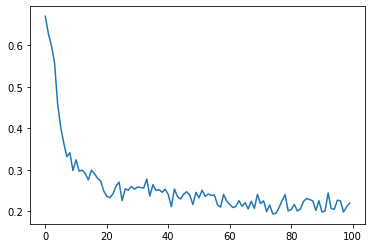

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


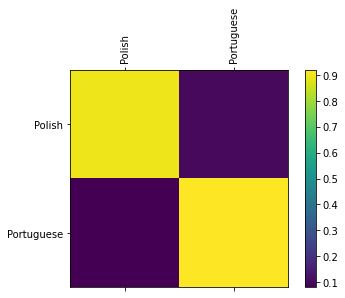

In [49]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [52]:
def predict(input_line, n_predictions=2):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('osmiornica')
predict('polvo')
predict('chomik')
predict('hamster')
predict('jezyk')
predict('lingua')


> osmiornica
(-0.02) Portuguese
(-4.00) Polish

> polvo
(-0.02) Portuguese
(-4.00) Polish

> chomik
(-0.01) Polish
(-4.27) Portuguese

> hamster
(-0.03) Portuguese
(-3.60) Polish

> jezyk
(-0.00) Polish
(-9.85) Portuguese

> lingua
(-0.10) Portuguese
(-2.35) Polish


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
